Import Libraries    

In [118]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from datetime import datetime
from sklearn import model_selection, preprocessing

# python core library for machine learning and data science
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.cluster import KMeans

RANDOM_STATE = 42

In [119]:
df_weekly_items_sales = pd.read_csv('./datasets/weekly_items_sales.csv', index_col=0)

/Users/artur/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [120]:
df_weekly_items_sales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8354260 entries, 0 to 8354259
Data columns (total 12 columns):
 #   Column              Dtype  
---  ------              -----  
 0   id                  object 
 1   item                object 
 2   category            object 
 3   department          object 
 4   store               object 
 5   store_code          object 
 6   region              object 
 7   date                object 
 8   quantity            int64  
 9   event               int64  
 10  sell_price          float64
 11  sell_price_imputed  float64
dtypes: float64(2), int64(2), object(8)
memory usage: 828.6+ MB


In [121]:
# specify the format since otherwise it might give some problems
df_weekly_items_sales["date"] = pd.to_datetime(df_weekly_items_sales["date"], format = "%Y-%m-%d")
df_weekly_items_sales.drop('sell_price', axis=1, inplace=True)
df_weekly_items_sales.rename(columns={'sell_price_imputed': 'sell_price'}, inplace=True)

In [122]:
df_weekly_items_sales.isnull().sum()

id            0
item          0
category      0
department    0
store         0
store_code    0
region        0
date          0
quantity      0
event         0
sell_price    0
dtype: int64

In [123]:
df_weekly_items_sales.head()

,id,item,category,department,store,store_code,region,date,quantity,event,sell_price
0,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,2011-01-30,0,0,12.7414
1,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,2011-02-06,0,1,12.7414
2,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,2011-02-13,0,0,12.7414
3,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,2011-02-20,0,0,12.7414
4,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,2011-02-27,0,0,12.7414


In [124]:
df_weekly_items_sales.describe(include=np.number).T

,count,mean,std,min,25%,50%,75%,max
quantity,8354260.0,7.863702,23.680201,0.000,0.0000,2.000,7.000,3976.00
event,8354260.0,0.094891,0.293064,0.000,0.0000,0.000,0.000,1.00
sell_price,8354260.0,5.562442,4.547930,0.012,2.6201,4.176,7.176,134.15


In [125]:
df_categorical_col = df_weekly_items_sales.describe(exclude=np.number).T
df_categorical_col['total'] = df_categorical_col['unique'] * df_categorical_col['freq']
df_categorical_col

/var/folders/pt/rrqbl2q559x5dkq3bsgd3gzh0000gn/T/ipykernel_12069/2085997088.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df_categorical_col = df_weekly_items_sales.describe(exclude=np.number).T


,count,unique,top,freq,first,last,total
id,8354260,30490,ACCESORIES_1_001_BOS_1,274,NaT,NaT,8354260
item,8354260,3049,ACCESORIES_1_001,2740,NaT,NaT,8354260
category,8354260,3,SUPERMARKET,3937380,NaT,NaT,11812140
department,8354260,7,SUPERMARKET_3,2255020,NaT,NaT,15785140
store,8354260,10,South_End,835426,NaT,NaT,8354260
store_code,8354260,10,BOS_1,835426,NaT,NaT,8354260
region,8354260,3,New York,3341704,NaT,NaT,10025112
date,8354260,274,2011-01-30 00:00:00,30490,2011-01-30,2016-04-24,8354260


In [126]:
df_weekly_items_sales[df_weekly_items_sales['id'] == 'ACCESORIES_1_001_NYC_1'].head()

,id,item,category,department,store,store_code,region,date,quantity,event,sell_price
822,ACCESORIES_1_001_NYC_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,2011-01-30,0,0,12.7414
823,ACCESORIES_1_001_NYC_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,2011-02-06,0,1,12.7414
824,ACCESORIES_1_001_NYC_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,2011-02-13,0,0,12.7414
825,ACCESORIES_1_001_NYC_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,2011-02-20,0,0,12.7414
826,ACCESORIES_1_001_NYC_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,2011-02-27,0,0,12.7414


In [127]:
df_weekly_items_sales['department'].unique()

array(['ACCESORIES_1', 'ACCESORIES_2', 'HOME_&_GARDEN_1',
       'HOME_&_GARDEN_2', 'SUPERMARKET_1', 'SUPERMARKET_2',
       'SUPERMARKET_3'], dtype=object)

In [128]:
df_weekly_items_sales["revenue"] = df_weekly_items_sales["quantity"] * df_weekly_items_sales["sell_price"]

In [129]:
COLS = ['quantity', 'sell_price', 'revenue']

In [130]:
# # set index
df_items_sales = df_weekly_items_sales.set_index("item")

# # groupby shop_id and item_id
df_items_sales = df_items_sales.groupby(['item', 'category', 'department']).agg({'quantity':np.sum, "sell_price":np.mean, "revenue":np.sum})

# # convert to dataframe and save the full dataframe
df_items_sales.reset_index(inplace = True)
df_items_sales

,item,category,department,quantity,sell_price,revenue
0,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,4093,11.470706,45037.9230
1,ACCESORIES_1_002,ACCESORIES,ACCESORIES_1,5059,5.276746,26708.0758
2,ACCESORIES_1_003,ACCESORIES,ACCESORIES_1,1435,3.947629,5656.3437
3,ACCESORIES_1_004,ACCESORIES,ACCESORIES_1,39175,5.977661,235347.8358
4,ACCESORIES_1_005,ACCESORIES,ACCESORIES_1,14621,3.838264,55670.1292
...,...,...,...,...,...,...
3044,SUPERMARKET_3_823,SUPERMARKET,SUPERMARKET_3,15388,3.345153,50854.0440
3045,SUPERMARKET_3_824,SUPERMARKET,SUPERMARKET_3,8325,3.026768,25414.5600
3046,SUPERMARKET_3_825,SUPERMARKET,SUPERMARKET_3,13526,4.933888,65787.5640
3047,SUPERMARKET_3_826,SUPERMARKET,SUPERMARKET_3,12188,1.535877,18719.7600


In [131]:
# # set index
df_category_sales = df_weekly_items_sales.set_index("item")

# # groupby category
df_category_sales = df_category_sales.groupby('category').agg({'quantity':np.sum, "sell_price":np.mean, "revenue":np.sum})

# # convert to dataframe and save the full dataframe
df_category_sales.reset_index(inplace = True)
df_category_sales

,category,quantity,sell_price,revenue
0,ACCESORIES,6124800,7.392877,3.034657e+07
1,HOME_&_GARDEN,14480670,6.801597,6.993592e+07
2,SUPERMARKET,45089939,3.939902,1.306688e+08


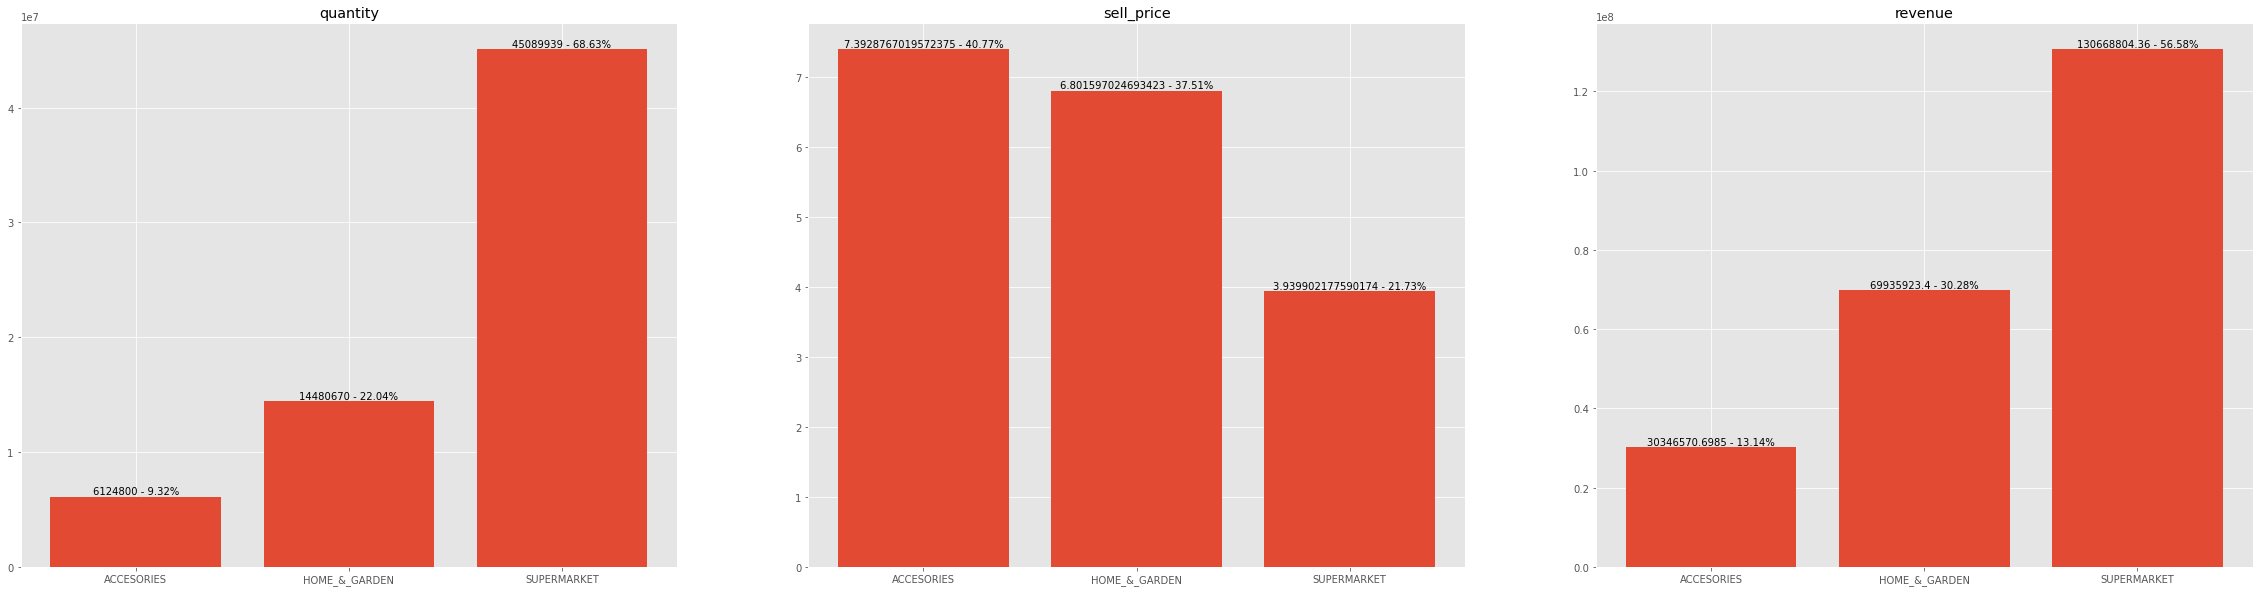

In [132]:
plt.figure(figsize = (40, 10))
for index, column in enumerate(COLS):
  plt.subplot(1,3, index + 1, title=column)
  # separete the data
  x = df_category_sales["category"].values
  y = df_category_sales[column].values
  y_pct = y/sum(y)

  # plot the data
  barplot = plt.bar(x, y)
  
  # add text to each column
  for rect, y_pct_ in zip(barplot, y_pct):
      y_pct_ = round(y_pct_*100, 2)
      height = rect.get_height()
      plt.text(
          rect.get_x() + rect.get_width()/2.0, 
          height, 
          f"{height} - {y_pct_}%", 
          ha = 'center', 
          va = "bottom"
      )
      

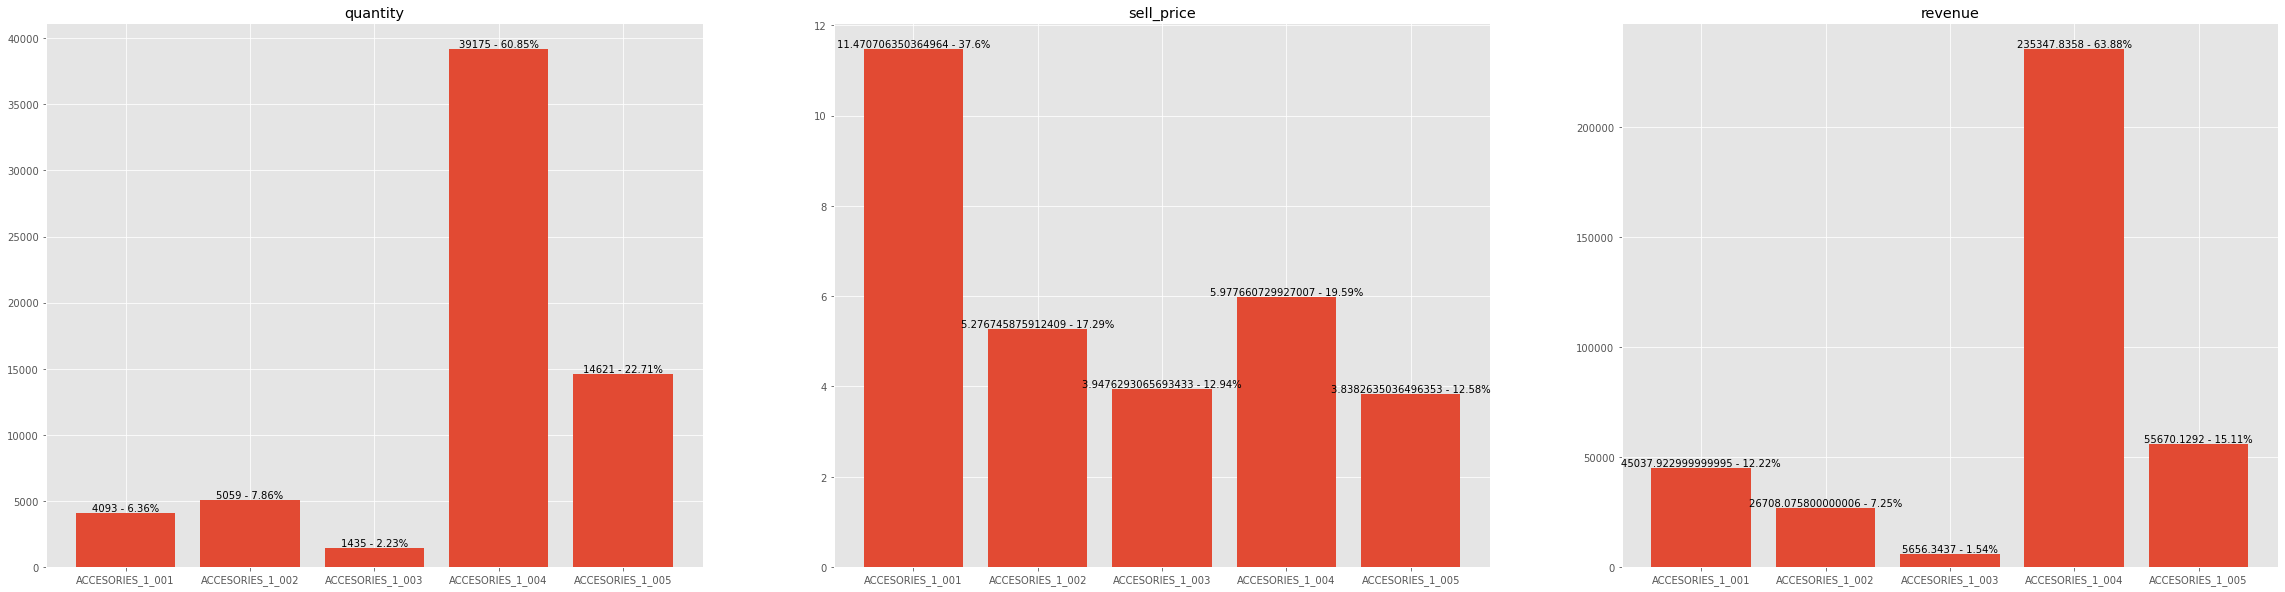

In [133]:
plt.figure(figsize = (40, 10))
for index, column in enumerate(COLS):
  plt.subplot(1,3, index + 1, title=column)
  df_items_sales.sort_values(column, ascending = True)
  df_items_sales_head = df_items_sales.head(5)
  # separete the data
  x = df_items_sales_head["item"].values
  y = df_items_sales_head[column].values
  y_pct = y/sum(y)

  # plot the data
  barplot = plt.bar(x, y)
  
  # add text to each column
  for rect, y_pct_ in zip(barplot, y_pct):
      y_pct_ = round(y_pct_*100, 2)
      height = rect.get_height()
      plt.text(
          rect.get_x() + rect.get_width()/2.0, 
          height, 
          f"{height} - {y_pct_}%", 
          ha = 'center', 
          va = "bottom"
      )

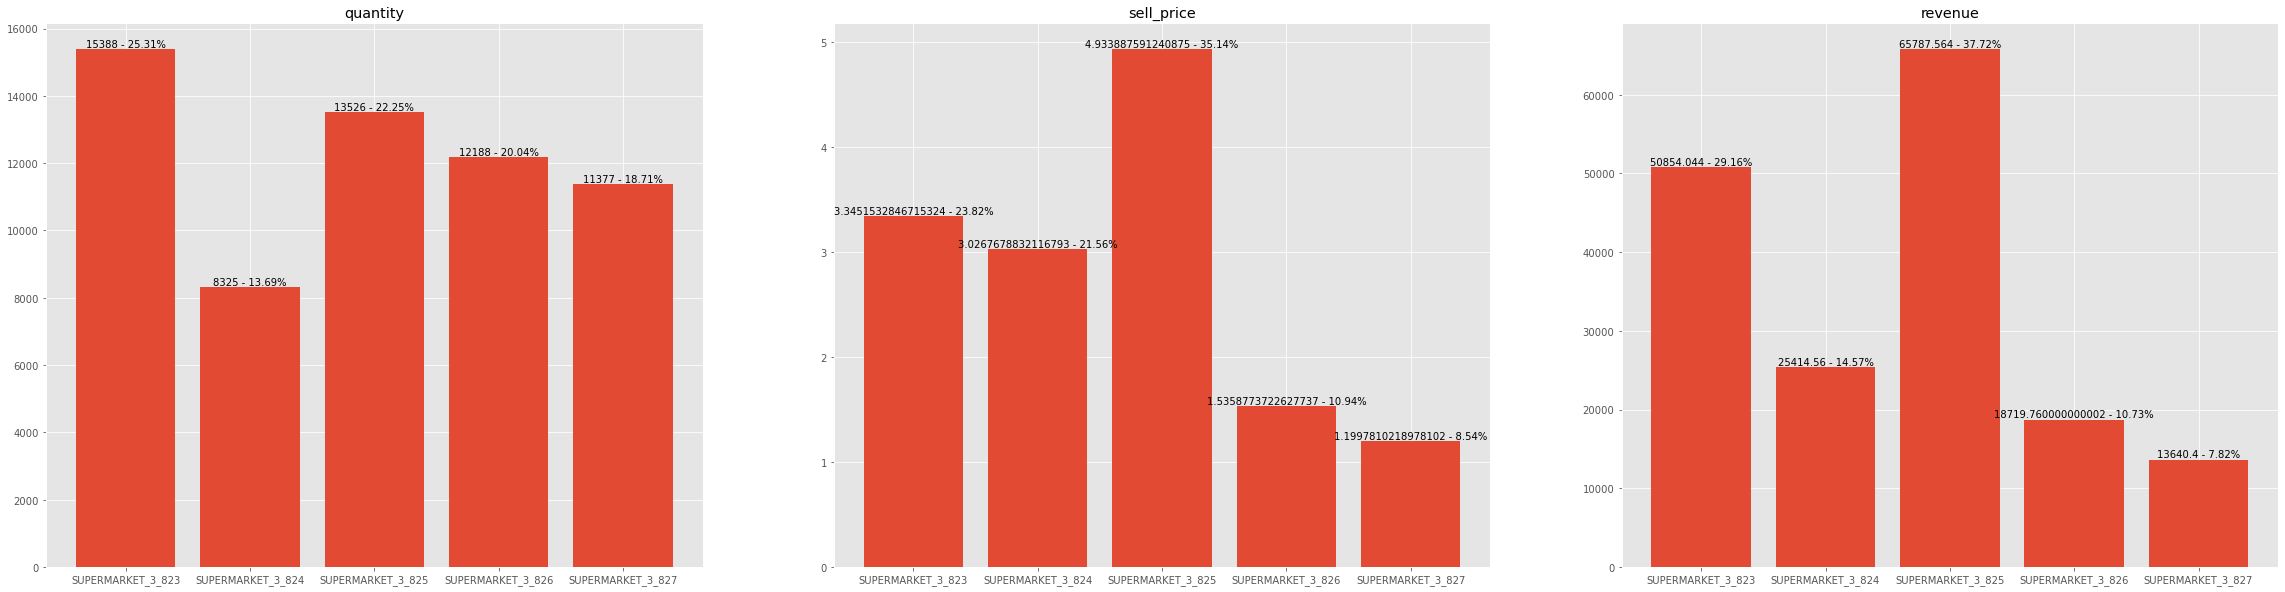

In [134]:
plt.figure(figsize = (40, 10))
for index, column in enumerate(COLS):
  plt.subplot(1,3, index + 1, title=column)
  df_items_sales.sort_values(column, ascending = True)
  df_items_sales_tail = df_items_sales.tail(5)
  # separete the data
  x = df_items_sales_tail["item"].values
  y = df_items_sales_tail[column].values
  y_pct = y/sum(y)

  # plot the data
  barplot = plt.bar(x, y)
  
  # add text to each column
  for rect, y_pct_ in zip(barplot, y_pct):
      y_pct_ = round(y_pct_*100, 2)
      height = rect.get_height()
      plt.text(
          rect.get_x() + rect.get_width()/2.0, 
          height, 
          f"{height} - {y_pct_}%", 
          ha = 'center', 
          va = "bottom"
      )

In [135]:
df_final = df_items_sales.set_index('item')[['quantity', 'sell_price', 'revenue']]
df_final

,quantity,sell_price,revenue
item,,,
ACCESORIES_1_001,4093,11.470706,45037.9230
ACCESORIES_1_002,5059,5.276746,26708.0758
ACCESORIES_1_003,1435,3.947629,5656.3437
ACCESORIES_1_004,39175,5.977661,235347.8358
ACCESORIES_1_005,14621,3.838264,55670.1292
...,...,...,...
SUPERMARKET_3_823,15388,3.345153,50854.0440
SUPERMARKET_3_824,8325,3.026768,25414.5600
SUPERMARKET_3_825,13526,4.933888,65787.5640


In [136]:
sse = {}

for k in range(2, 15):
    print(f"Fitting pipe with {k} clusters")
    clustering_model = KMeans(n_clusters = k)
    clustering_model.fit(df_final)
    sse[k] = clustering_model.inertia_


Fitting pipe with 2 clusters
Fitting pipe with 3 clusters
Fitting pipe with 4 clusters
Fitting pipe with 5 clusters
Fitting pipe with 6 clusters
Fitting pipe with 7 clusters
Fitting pipe with 8 clusters
Fitting pipe with 9 clusters
Fitting pipe with 10 clusters
Fitting pipe with 11 clusters
Fitting pipe with 12 clusters
Fitting pipe with 13 clusters
Fitting pipe with 14 clusters


In [137]:
sse

{2: 21648566618212.254,
 3: 13173708513910.287,
 4: 7981580347808.8955,
 5: 6071414825936.183,
 6: 4958247744348.136,
 7: 4283917448084.5415,
 8: 3688000279165.5347,
 9: 3211616666090.279,
 10: 2760989461775.2075,
 11: 2357408302234.935,
 12: 2120096390622.966,
 13: 1881877479673.7017,
 14: 1723095729973.5674}

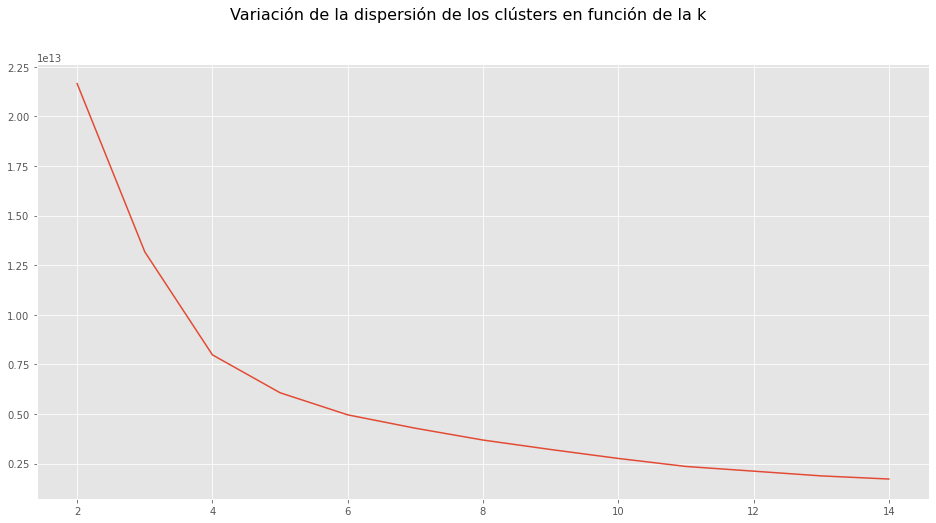

In [138]:
fig = plt.figure(figsize = (16, 8))
ax = fig.add_subplot()

x_values = list(sse.keys())
y_values = list(sse.values())

ax.plot(x_values, y_values, label = "Inertia/dispersión de los clústers")
fig.suptitle("Variación de la dispersión de los clústers en función de la k", fontsize = 16);

In [139]:
clustering_model = KMeans(n_clusters = 6)
clustering_model.fit(df_final)

KMeans(n_clusters=6)

In [140]:
clustering_model.cluster_centers_

array([[8.12003962e+03, 5.11765526e+00, 2.83237334e+04],
       [1.63613536e+05, 7.44848098e+00, 6.55936213e+05],
       [2.73962092e+04, 5.95993341e+00, 9.14219798e+04],
       [5.77163667e+05, 3.24361314e+00, 1.46192605e+06],
       [9.59505205e+04, 7.39143723e+00, 3.88187521e+05],
       [5.60448041e+04, 7.07690563e+00, 2.03808964e+05]])

In [141]:
labels = clustering_model.predict(df_final)
df_final["cluster"] = labels

In [142]:
df_final

,quantity,sell_price,revenue,cluster
item,,,,
ACCESORIES_1_001,4093,11.470706,45037.9230,0
ACCESORIES_1_002,5059,5.276746,26708.0758,0
ACCESORIES_1_003,1435,3.947629,5656.3437,0
ACCESORIES_1_004,39175,5.977661,235347.8358,5
ACCESORIES_1_005,14621,3.838264,55670.1292,0
...,...,...,...,...
SUPERMARKET_3_823,15388,3.345153,50854.0440,0
SUPERMARKET_3_824,8325,3.026768,25414.5600,0
SUPERMARKET_3_825,13526,4.933888,65787.5640,2


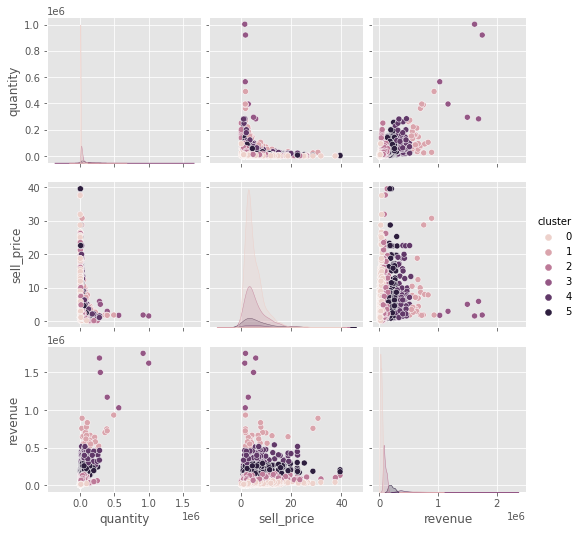

In [143]:
selected_columns = ['quantity', 'sell_price', 'revenue']

sns.pairplot(df_final, vars = selected_columns, hue = 'cluster');

In [144]:
ficha_df = pd.DataFrame()

In [145]:
for i, col in enumerate(selected_columns):
    resumen_data = df_final[["cluster", col]].groupby("cluster").describe().T[1:]
    ficha_df = ficha_df.append(resumen_data)

In [146]:
resumen_data

cluster                  0              1              2             3  \
revenue mean  28226.790029  655936.213296   91124.913075  1.461926e+06   
        std   15860.297132  110876.162073   25169.405364  2.956065e+05   
        min     558.879300  498823.200000   33190.716000  1.030109e+06   
        25%   14763.016025  566732.133000   70460.136375  1.253549e+06   
        50%   26858.651100  642405.596500   85274.532000  1.562131e+06   
        75%   40376.809125  708573.316125  109603.227000  1.674683e+06   
        max   64053.292100  933370.272000  155467.211200  1.754296e+06   

cluster                   4              5  
revenue mean  387069.056588  203097.402598  
        std    62520.217282   42766.377997  
        min   274261.200000  131088.550000  
        25%   339841.352175  166758.804000  
        50%   376423.158000  197658.732000  
        75%   434951.643000  235347.835800  
        max   536943.117900  302579.912500

In [147]:
# generamos nuestro multiindex
out_index = [
    "Num",
    "Cost",
    "Money",
]

inner_index = [
    "Cantidad",
    "Price",
    "Money",
]

estadisticos = ["Media", "Desviación", "Mínimo", "Perc. 25", "Perc. 50", "Perc. 75", "Máximo"]

new_multi_index = []

for oi, ii, in zip(out_index, inner_index):
    for es in estadisticos:
        new_multi_index.append((oi, ii, es))
        
new_multi_index

[('Num', 'Cantidad', 'Media'),
 ('Num', 'Cantidad', 'Desviación'),
 ('Num', 'Cantidad', 'Mínimo'),
 ('Num', 'Cantidad', 'Perc. 25'),
 ('Num', 'Cantidad', 'Perc. 50'),
 ('Num', 'Cantidad', 'Perc. 75'),
 ('Num', 'Cantidad', 'Máximo'),
 ('Cost', 'Price', 'Media'),
 ('Cost', 'Price', 'Desviación'),
 ('Cost', 'Price', 'Mínimo'),
 ('Cost', 'Price', 'Perc. 25'),
 ('Cost', 'Price', 'Perc. 50'),
 ('Cost', 'Price', 'Perc. 75'),
 ('Cost', 'Price', 'Máximo'),
 ('Money', 'Money', 'Media'),
 ('Money', 'Money', 'Desviación'),
 ('Money', 'Money', 'Mínimo'),
 ('Money', 'Money', 'Perc. 25'),
 ('Money', 'Money', 'Perc. 50'),
 ('Money', 'Money', 'Perc. 75'),
 ('Money', 'Money', 'Máximo')]

In [148]:
def generate_multiindex(list_of_tuples, names):
    return pd.MultiIndex.from_tuples(list_of_tuples, names = names)

In [149]:
names = ["Grupo Indicadores", "Indicador", "Estadístico"]
index_ficha = generate_multiindex(new_multi_index, names)
ficha_df.set_index(index_ficha, inplace = True)

In [150]:
tamaño_clusters = df_final.groupby("cluster").size().to_frame().T
tamaño_clusters.set_index(generate_multiindex([("General", "Clúster", "Tamaño")] , names), inplace = True)

In [151]:
ficha_df = tamaño_clusters.append(ficha_df)

In [152]:
ficha_df.style.background_gradient(cmap = 'Blues', axis = 1)